In [1]:
import os
import io
import h5py
import torch
import ipywidgets
import numpy as np
from torch import nn
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import XLNetTokenizer, XLNetModel
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
training = 1
num_epoch = 25
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_root = os.path.join("/", "kaggle", "input", "flowershd5dataset")
kernel_root = os.path.join("/", "kaggle", "input", "text-to-image-xlnet-pytorch")

In [3]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = XLNetModel.from_pretrained("xlnet-base-cased")

    def forward(self, input_ids, token_type_ids, attention_mask):
        hidden = self.transformer(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        ).last_hidden_state
        context = hidden.mean(dim=1)
        context = context.view(*context.shape, 1, 1)
        return context

In [4]:
class Generator(nn.Module):
    def __init__(self, nz=100, nt=768, nc=3, ngf=64):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz + nt, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
        )

            # Completed - TODO: check out paper's code and add layers if required

            ##there are more conv2d layers involved here in 
            # https://github.com/reedscot/icml2016/blob/master/main_cls.lua
        self.layer2 = nn.Sequential(
            nn.Conv2d(ngf*8,ngf*2,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*2,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*8,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # nn.SELU(True),
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(ngf * 4),
            # nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
        )
            
            # Completed - TODO: check out paper's code and add layers if required
            
            ##there are more conv2d layers involved here in 
            # https://github.com/reedscot/icml2016/blob/master/main_cls.lua
            
        self.layer6 = nn.Sequential(
            nn.Conv2d(ngf*4,ngf,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(ngf,ngf,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(ngf,ngf*4,3,1,1),
            nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer9 = nn.Sequential(  
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
            
            # state size. (ngf*2) x 16 x 16
        )
        self.layer10 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),

            # state size. (ngf) x 32 x 32
        )
        self.layer11 = nn.Sequential(
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  
    def forward(self,noise,encoded_text):
        x = torch.cat([noise,encoded_text],dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, nt=768):
        super().__init__()
        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),

            nn.Conv2d(ndf*8,ndf*2,1,1),
            # nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer5 = nn.Sequential(

            nn.Conv2d(ndf*2,ndf*2,3,1,1),
            # nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer6 = nn.Sequential(

            nn.Conv2d(ndf*2,ndf*8,3,1,1),
            # nn.Dropout2d(inplace=True),            
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.concat_image_n_text = nn.Sequential(
            nn.Conv2d(ndf * 8 + nt, ndf * 8, 1, 1, 0, bias=False), ## TODO: Might want to change the kernel size and stride
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf * 8, 2, 4, 1, 0, bias=False),
            nn.Flatten(start_dim=1)
        )

    def forward(self, x, encoded_text):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
#         print(x.shape)
        x = torch.cat([x, encoded_text.repeat(1, 1, 4, 4)], dim=1)
        x = self.concat_image_n_text(x)
        return x

In [6]:
class TrainDataset:
    def __init__(self, dataset_root, kernel_root):
        self.tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

        if os.path.exists(os.path.join(kernel_root, "data.npy")):
            self.data = np.load(os.path.join(kernel_root, "data.npy"), allow_pickle=True)
        else:
            f = h5py.File(os.path.join(dataset_root, "data", "flowers", "flowers.hdf5"), mode="r")
            self.data = self.prepareData(f['train'])
        np.save('data.npy', self.data)
        self.max_seq_len = max(map(lambda x: len(x["text"]["input_ids"]), self.data))

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(90, 90)),
            transforms.RandomRotation(degrees=(180, 180)),
            transforms.RandomRotation(degrees=(270, 270)),
            transforms.RandomVerticalFlip(p=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def prepareData(self, data):
        preparedData = []
        for idx, img_name in enumerate(tqdm(data)):
            image = np.array(Image.open(io.BytesIO(bytes(np.array(data[img_name]['img'])))).resize((256,256)))
            text = np.array(data[img_name]['txt']).item().strip()
            input_ids = self.tokenizer.encode(text)
            token_type_ids = [0] * (len(input_ids) - 1) + [1]
            attention_mask = [1] * len(token_type_ids)
            preparedData.append({
                "image": image,
                "text": {
                    "input_ids": input_ids,
                    "token_type_ids": token_type_ids,
                    "attention_mask": attention_mask
                },
            })
        return preparedData

    def padTokens(self, text_dict):
        pad_len = self.max_seq_len - sum(text_dict["attention_mask"])
        text_dict['input_ids'] =  [5] * pad_len + text_dict['input_ids'] # <pad> = 5
        text_dict['token_type_ids'] =  [2] * pad_len + text_dict['token_type_ids']
        text_dict['attention_mask'] = [0] * pad_len + text_dict['attention_mask']   
        return text_dict

    @staticmethod
    def collate_fn_module(batch, idx):
        images, texts = [], {}
        for data in batch:
            images.append(data[idx][0])
            for key in data[idx][1]:
                if key not in texts:
                    texts[key] = []
                texts[key].append(data[0][1][key])

        images = torch.stack(images).to(device)
        for key in texts:
            texts[key] = torch.tensor(texts[key]).to(device)
        return images, texts

    def collate_fn(self, batch):
        right_images, right_texts = self.collate_fn_module(batch, 0)
        wrong_images, wrong_texts = self.collate_fn_module(batch, 1)
        return (right_images, right_texts), (wrong_images, wrong_texts)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, right_idx):
        right_data = self.data[right_idx].copy()
        right_image = self.transforms(Image.fromarray(right_data["image"]))
        right_text = self.padTokens(right_data["text"].copy())

        wrong_idx = np.random.choice([(i) for i in range(len(self.data)) if i != right_idx])
        wrong_data = self.data[wrong_idx].copy()
        wrong_image = self.transforms(Image.fromarray(wrong_data["image"]))
        wrong_text = self.padTokens(wrong_data["text"].copy())
        return (right_image, right_text), (wrong_image, wrong_text)

In [7]:
%%time
train_dataset = TrainDataset(dataset_root, kernel_root)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

CPU times: user 6.06 s, sys: 15.4 s, total: 21.5 s
Wall time: 1min 9s


In [8]:
def visualize(image, text, tokenizer=None, ax = None, title = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (10, 10))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))
    if tokenizer== None:
        pass
    else:
        ax.set_xlabel(tokenizer.decode([t for t in text["input_ids"] if t != 5]))
    

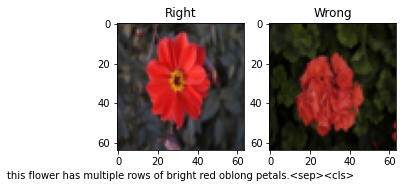

In [9]:
idx = np.random.randint(len(train_dataset))
right, wrong = train_dataset[idx]
_, axs = plt.subplots(1, 2, figsize=(5, 5))
visualize(*right, train_dataset.tokenizer, axs[0], "Right")
visualize(*wrong, ax = axs[1], title = "Wrong")
plt.show()

In [10]:
if os.path.exists(os.path.join(kernel_root, 'checkpoint.pth')):
    checkpoint = torch.load(os.path.join(kernel_root, 'checkpoint.pth'), map_location=device)
    torch.save(checkpoint, "checkpoint.pth")
else:
    checkpoint = {}

In [11]:
train_indices = checkpoint.get('train_indices', None)
valid_indices = checkpoint.get('valid_indices', None)
if train_indices is None or valid_indices is None:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    splitter = sss.split(train_dataset, np.array([len(x["text"]["input_ids"])%10 for x in train_dataset.data]))
    train_indices, valid_indices = next(splitter)
# Creating PT data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, collate_fn=train_dataset.collate_fn, drop_last=True)

In [12]:
models = {
    "text_encoder": TextEncoder().to(device),
    "generator": Generator().to(device),
    "discriminator": Discriminator().to(device)
}
optimizers = {}
schedulers = {}
criterion = nn.CrossEntropyLoss()
learning_rates = {"text_encoder": 1e-4, "generator": 5e-4, "discriminator": 1e-4}
for key in models:
    if key == "text_encoder": continue
    models[key].load_state_dict(checkpoint.get("models", {}).get(key, models[key].state_dict()))
    # Prepare optimizer and schedule (linear warmup and decay)
    optimizers[key] = torch.optim.Adam(models[key].parameters(), lr=learning_rates[key], weight_decay=1e-6)
    optimizers[key].load_state_dict(checkpoint.get("optimizers", {}).get(key, optimizers[key].state_dict()))
    schedulers[key] = torch.optim.lr_scheduler.StepLR(optimizers[key], step_size=50, gamma=0.1, last_epoch=-1)
    schedulers[key].load_state_dict(checkpoint.get("schedulers", {}).get(key, schedulers[key].state_dict()))

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [13]:
def valid():
    total_dis_loss, total_gen_loss = 0, 0
    total_dis_score, total_gen_score = 0, 0
    template = "Dis Loss: {:.4f}, Dis Score: {:.4f}, Gen Loss: {:.4f}, Gen Score: {:.4f}"
    for key in models:
        models[key].eval()
    loader = tqdm(valid_loader, desc = f"Validating")
    for idx, ((right_images, right_texts), (wrong_images, wrong_texts)) in enumerate(loader, start=1):
        # Execute
        with torch.no_grad():
            enc_right_texts = models["text_encoder"](**right_texts).detach()
            enc_wrong_texts = models["text_encoder"](**wrong_texts).detach()

            noise = torch.randn((len(right_images), 100, 1, 1),device = device)
            ones = torch.ones((len(right_images)), dtype=torch.long, device=device)
            zeros = torch.zeros((len(right_images)), dtype=torch.long, device=device)
            fake_images = models["generator"](noise, enc_right_texts)

            dis_right_logits = models["discriminator"](right_images, enc_right_texts)
            dis_wrong_text_logits =  models["discriminator"](right_images, enc_wrong_texts)
            dis_wrong_image_logits =  models["discriminator"](wrong_images, enc_right_texts)
            dis_fake_logits = models["discriminator"](fake_images.detach(), enc_right_texts)

            dis_real_loss = criterion(dis_right_logits, ones)
            dis_wrong_text_loss = criterion(dis_wrong_text_logits, zeros)
            dis_wrong_image_loss = criterion(dis_wrong_image_logits, zeros)
            dis_fake_loss = criterion(dis_fake_logits, zeros)
            dis_loss = dis_real_loss + 0.25*dis_wrong_text_loss + 0.25*dis_wrong_image_loss + 0.5*dis_fake_loss

            dis_fake_logits = models["discriminator"](fake_images, enc_right_texts)
            gen_loss = criterion(dis_fake_logits, ones)

        dis_score, gen_score = torch.tensor(0), torch.tensor(0)

        total_dis_loss += dis_loss.item(); total_gen_loss += gen_loss.item()
        total_dis_score += dis_score.item(); total_gen_score += gen_score.item()
        # print statistics
        loader.set_postfix_str(template.format(dis_loss, dis_score, gen_loss, gen_score))
        loader.update()
        # Clear variable
        del right_images; del right_texts; del wrong_images; del wrong_texts
        del enc_right_texts; del enc_wrong_texts; del noise; del fake_images
        del ones; del zeros; del dis_right_logits; del dis_wrong_text_logits
        del dis_wrong_image_logits; del dis_fake_logits; del dis_real_loss
        del dis_wrong_text_loss; del dis_wrong_image_loss; del dis_fake_loss
        del dis_loss; del gen_loss; del dis_score; del gen_score
        torch.cuda.empty_cache()
    template = template.format(total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx)
    loader.write(f"Validated | {template}")
    return total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx


In [14]:
def train():
    total_dis_loss, total_gen_loss = 0, 0
    total_dis_score, total_gen_score = 0, 0
    template = "Dis Loss: {:.4f}, Dis Score: {:.4f}, Gen Loss: {:.4f}, Gen Score: {:.4f}"
    for key in models:
        models[key].train()
    loader = tqdm(train_loader, desc = f"Training")
    for idx, ((right_images, right_texts), (wrong_images, wrong_texts)) in enumerate(loader, start=1):
        # Execute
        enc_right_texts = models["text_encoder"](**right_texts).detach()
        enc_wrong_texts = models["text_encoder"](**wrong_texts).detach()

        noise = torch.randn((len(right_images), 100, 1, 1), device=device)
        ones = torch.ones((len(right_images)), dtype=torch.long, device=device)
        zeros = torch.zeros((len(right_images)), dtype=torch.long, device=device)
        fake_images = models["generator"](noise, enc_right_texts)

        dis_right_logits = models["discriminator"](right_images, enc_right_texts)
        dis_wrong_text_logits = models["discriminator"](right_images, enc_wrong_texts)
        dis_wrong_image_logits = models["discriminator"](wrong_images, enc_right_texts)
        dis_fake_logits = models["discriminator"](fake_images.detach(), enc_right_texts)

        dis_real_loss = criterion(dis_right_logits, ones)
        dis_wrong_text_loss = criterion(dis_wrong_text_logits, zeros)
        dis_wrong_image_loss = criterion(dis_wrong_image_logits, zeros)
        dis_fake_loss = criterion(dis_fake_logits, zeros)
        dis_loss = dis_real_loss + 0.25*dis_wrong_text_loss + 0.25*dis_wrong_image_loss + 0.5*dis_fake_loss

        optimizers["discriminator"].zero_grad()
        dis_loss.backward()
        optimizers["discriminator"].step()

        dis_fake_logits = models["discriminator"](fake_images, enc_right_texts)
        gen_loss = criterion(dis_fake_logits, ones)
        optimizers["generator"].zero_grad()
        gen_loss.backward()
        optimizers["generator"].step()

        dis_score, gen_score = torch.tensor(0), torch.tensor(0)

        total_dis_loss += dis_loss.item(); total_gen_loss += gen_loss.item()
        total_dis_score += dis_score.item(); total_gen_score += gen_score.item()
        # print statistics
        loader.set_postfix_str(template.format(dis_loss, dis_score, gen_loss, gen_score))
        loader.update()
        # Clear variable
        del right_images; del right_texts; del wrong_images; del wrong_texts
        del enc_right_texts; del enc_wrong_texts; del noise; del fake_images
        del ones; del zeros; del dis_right_logits; del dis_wrong_text_logits
        del dis_wrong_image_logits; del dis_fake_logits; del dis_real_loss
        del dis_wrong_text_loss; del dis_wrong_image_loss; del dis_fake_loss
        del dis_loss; del gen_loss; del dis_score; del gen_score
        torch.cuda.empty_cache()
    template = template.format(total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx)
    loader.write(f"Trained | {template}")
    for key in schedulers:
        schedulers[key].step()
    return total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx

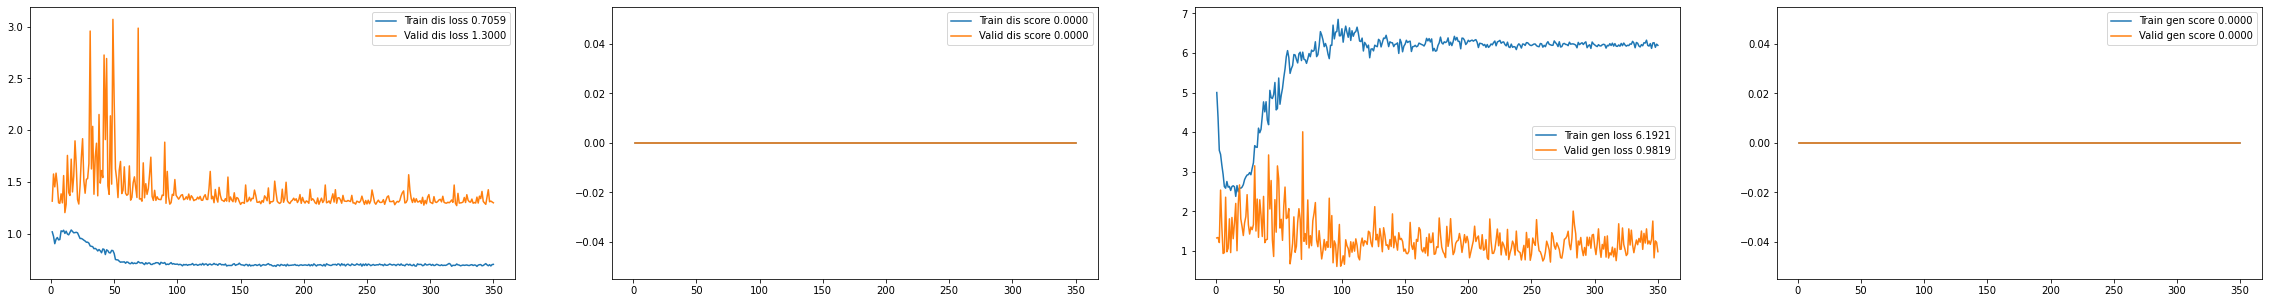

In [15]:
train_data = checkpoint.get('train_data', np.empty((0, 4)))
valid_data = checkpoint.get('valid_data', np.empty((0, 4)))
epoch_data = checkpoint.get('epoch_data', [])
# del checkpoint
def plot_training_data(ax, epoch_data, train_data, valid_data):
    ax[0].clear(); ax[1].clear(); ax[2].clear(); ax[3].clear()
    ax[0].plot(epoch_data, train_data[:, 0], label = f"Train dis loss {train_data[-1, 0]:.4f}")
    ax[0].plot(epoch_data, valid_data[:, 0], label = f"Valid dis loss {valid_data[-1, 0]:.4f}")
    ax[1].plot(epoch_data, train_data[:, 1], label = f"Train dis score {train_data[-1, 1]:.4f}")
    ax[1].plot(epoch_data, valid_data[:, 1], label = f"Valid dis score {valid_data[-1, 1]:.4f}")
    ax[2].plot(epoch_data, train_data[:, 2], label = f"Train gen loss {train_data[-1, 2]:.4f}")
    ax[2].plot(epoch_data, valid_data[:, 2], label = f"Valid gen loss {valid_data[-1, 2]:.4f}")
    ax[3].plot(epoch_data, train_data[:, 3], label = f"Train gen score {train_data[-1, 3]:.4f}")
    ax[3].plot(epoch_data, valid_data[:, 3], label = f"Valid gen score {valid_data[-1, 3]:.4f}")
    ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend()
if epoch_data:
    fig, ax = plt.subplots(1, 4, figsize=(10*4, 5))
    plot_training_data(ax, epoch_data, train_data, valid_data)
    plt.show()

In [16]:
loader = tqdm(range(len(epoch_data), len(epoch_data) + num_epoch * training), desc = "Epoch")
board = ipywidgets.Output()
if training: display.display(board)
graph = display.display(ipywidgets.widgets.HTML(f"<b>Training statred: {bool(training)}</b>"), display_id = True)
for i in loader:
    with board:
        epoch_data.append(i+1)
        # Make grid
        fig, ax = plt.subplots(1, 4, figsize=(10*4, 5))
        # Close figure
        plt.close(fig)
        train_data = np.append(train_data, [train()], axis = 0)
        valid_data = np.append(valid_data, [valid()], axis = 0)
        # Visualize
        plot_training_data(ax, epoch_data, train_data, valid_data)
        graph.update(fig)
        # Clear all progress bar with in board widget
        display.clear_output()
        graph = display.display(fig, display_id = True)
    # Save model
    params = {
        'models': dict([(key, models[key].state_dict()) for key in models]),
        'optimizers': dict([(key, optimizers[key].state_dict()) for key in optimizers]),
        'schedulers': dict([(key, schedulers[key].state_dict()) for key in schedulers]),
        'train_indices': train_indices,
        'valid_indices': valid_indices,
        'train_data': train_data,
        'valid_data': valid_data,
        'epoch_data': epoch_data
    }
    torch.save(params, "/kaggle/working/checkpoint.pth")
loader.write("Done!")

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Output()

HTML(value='<b>Training statred: True</b>')

Done!


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load("/kaggle/input/text-to-image-xlnet-pytorch/checkpoint.pth", map_location=device)
models = checkpoint.get("models")

te =  TextEncoder()
gen = Generator()
disc = Discriminator()

te.load_state_dict(models["text_encoder"])
te.eval()

gen.load_state_dict(models["generator"])
gen.eval()

disc.load_state_dict(models["discriminator"])
disc.eval()

models = {
    "text_encoder": te.to(device),
    "generator": gen.to(device),
    "discriminator": disc.to(device)
}

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/results/output_1.png'

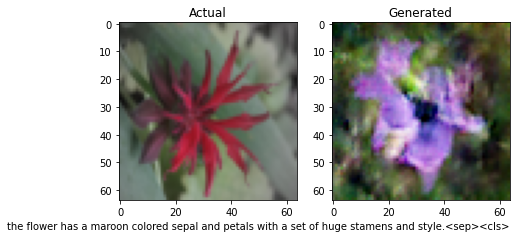

In [18]:
#os.mkdir("/kaggle/working/results")

def visualize(image, text, tokenizer=None, ax = None, title = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (10, 10))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))

for i in range(1, 101):
    idx = np.random.randint(len(train_dataset))
    (image, text), _ = train_dataset[idx]
    params = {}
    for key in text:
        params[key] = torch.tensor(text[key], device=device)[None]
    for key in models:
         models[key].eval()
    enc_text = models["text_encoder"](**params)
    noise = torch.randn((1, 100, 1, 1), device=device)
    gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()
    _, axs = plt.subplots(1, 2, figsize=(7, 7))
    visualize(image, text, train_dataset.tokenizer, axs[0], "Actual")
    visualize(gen_image, text, None, axs[1], "Generated")
    plt.xlabel(train_dataset.tokenizer.decode([t for t in text["input_ids"] if t != 5]), loc = "right")
    plt.savefig(f"/kaggle/working/results/output_{i}")
    plt.show()

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/results", 'zip', "/kaggle/working/results")